In [21]:
import logging
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier #Change
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay,
                             classification_report)
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [22]:
# Step 1: Upload Data Set
df_raw = pd.read_csv("skbr_cells.csv")
df_raw.info()
# Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [23]:
# Show sample
df_raw.sample(10, random_state=2024)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1781,208412526,Train,PS,104.208986,372,52.304225,114.822535,38.219718,58.383099,1.197572,...,18568,40408,13568,20726,33.307494,37.597455,49.828379,15.956169,81,277
856,208340336,Train,PS,47.697886,155,77.885135,74.864865,181.189189,180.020270,1.210777,...,11527,10933,26816,26643,61.789587,180.934039,156.294311,13.289130,316,136
1281,208322195,Test,PS,79.971064,393,46.592000,169.530667,88.418667,69.330667,1.364899,...,17472,63200,33157,25999,39.645179,79.688849,68.986743,20.053071,423,228
1878,208332514,Test,PS,57.764663,202,38.015544,4.823834,83.751295,8.056995,1.339736,...,7337,739,16164,1555,25.612796,53.556327,19.686977,11.975392,328,55
1013,208405198,Test,PS,61.292430,380,104.787879,247.005510,50.143251,56.165289,1.236340,...,38038,89301,18202,20388,59.918187,73.120312,72.884340,17.981055,62,172
128,208384284,Test,PS,16.587410,212,22.103448,2.113300,44.640394,83.610837,1.232394,...,4487,227,9062,16973,16.705037,23.722196,53.352913,14.008268,70,76
133,208402927,Test,PS,48.768215,277,35.267925,60.086792,82.483019,34.471698,1.451296,...,9346,15659,21858,9135,28.352497,67.968366,52.255109,23.600570,438,136
650,208332444,Train,WS,129.876395,162,17.374194,61.761290,22.664516,61.154839,1.102719,...,2693,9419,3513,9479,15.580446,28.853641,55.956336,11.397614,355,17
206,208320986,Test,WS,108.508951,309,85.894915,145.813559,121.725424,16.301695,1.240323,...,25339,42721,35909,4809,56.524413,186.966060,22.175582,17.154507,130,77
1495,208405392,Train,WS,66.827049,414,61.134177,259.030380,87.807595,190.098734,1.089681,...,24148,101923,34684,75089,45.452713,108.516269,155.754230,21.776303,364,362


In [24]:
# Step 2: Transform and preproccess
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # Replace withespace whit _
        .str.replace(r'\W', '', regex= True) # Replace non-alphabetic character with '' 
        .str.lower() # Lowercase
        .str.slice(0,40), axis= 1 # Cut the text to a maximum of 40 characters
    )
    .loc[:,['perimch1','eqsphereareach1','entropyintench1','class']] # Select specific columns
    .drop_duplicates() # Eliminated duplicates
    .rename(columns= {'class': 'target'}) # Rename the column
    .astype({'target': 'category'}) # Convert to categorical variable
)

In [25]:
# Move target to first column
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)

In [26]:
# Step 3: EDA
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['target'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 1671 to 321
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   target           1615 non-null   category
 1   perimch1         1615 non-null   float64 
 2   eqsphereareach1  1615 non-null   float64 
 3   entropyintench1  1615 non-null   float64 
dtypes: category(1), float64(3)
memory usage: 52.2 KB


In [27]:
# Describe
display(df_train.describe(include= 'number').T)
display(df_train.describe(include= 'category').T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1615.0,89.415197,39.434955,47.489176,64.366964,77.500830,99.709703,392.284364
eqsphereareach1,1615.0,1281.806143,843.478759,603.755102,779.850340,1027.222222,1450.689342,8746.063492
entropyintench1,1615.0,6.585149,0.757554,4.707829,6.028410,6.582916,7.058570,9.475700


,count,unique,top,freq
target,1615,2,PS,1040


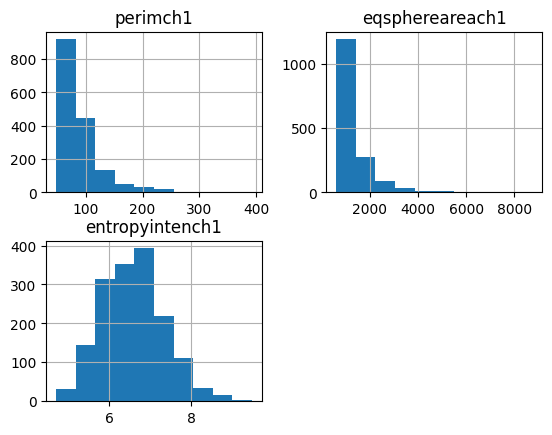

In [28]:
# Univariate analysis
df_train.hist()
plt.show()

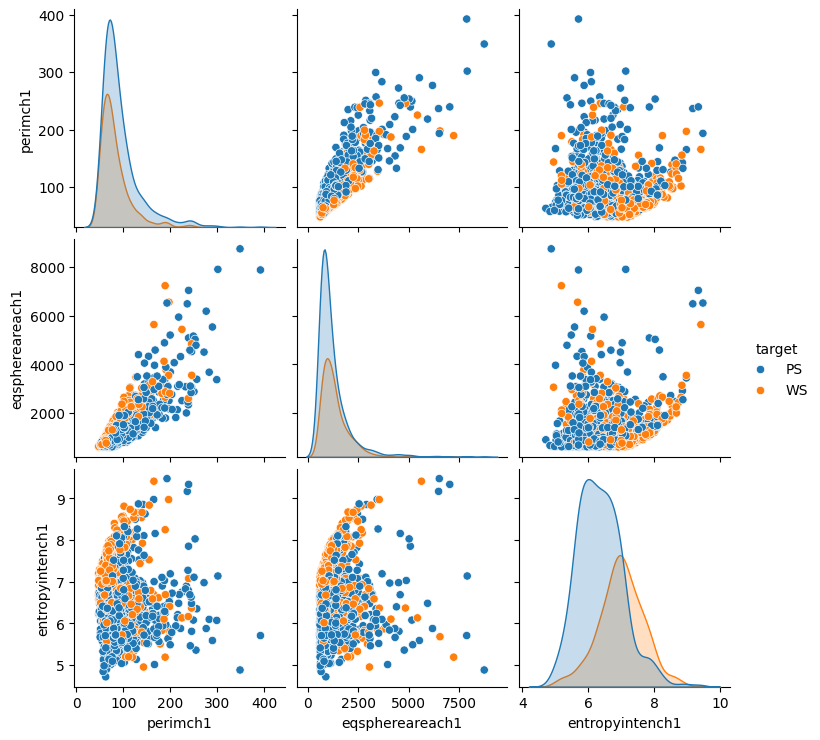

In [29]:
sns.pairplot(data= df_train, hue= 'target')
plt.show()

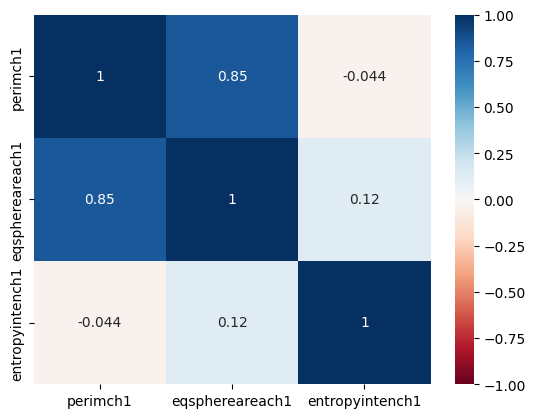

In [30]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap="RdBu")
plt.show()

In [31]:
X_train = df_train.drop('target', axis= 1).reset_index(drop= True) # Separate independent values ​​from dependent variables for TRAIN
y_train = df_train['target'].reset_index(drop= True) # Select independent values for TRAIN
X_test = df_test.drop('target', axis= 1).reset_index(drop= True) # Separate independent values ​​from dependent variables for TEST
y_test = df_test['target'].reset_index(drop= True) # Select independent values for TEST

In [32]:
# Encoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [33]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train_enc)

RandomForestClassifier()

Accuracy: 0.78
f1_score: 0.66
              precision    recall  f1-score   support

          PS       0.80      0.87      0.83       260
          WS       0.72      0.60      0.66       144

    accuracy                           0.78       404
   macro avg       0.76      0.74      0.75       404
weighted avg       0.77      0.78      0.77       404



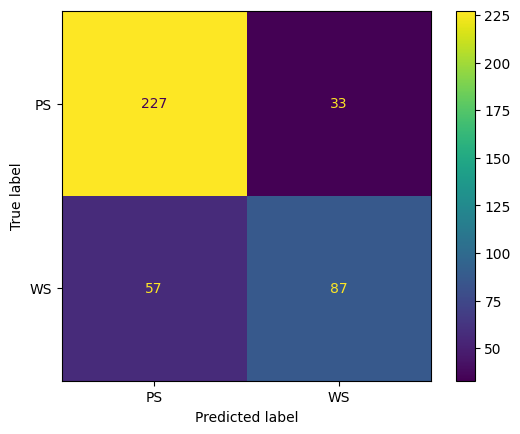

In [34]:
y_pred = clf_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_pred):.2f}')
print(f'f1_score: {f1_score(y_test_enc, y_pred):.2f}')
print(classification_report(y_test_enc, y_pred, target_names= label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, display_labels= label_encoder.classes_)
plt.show()

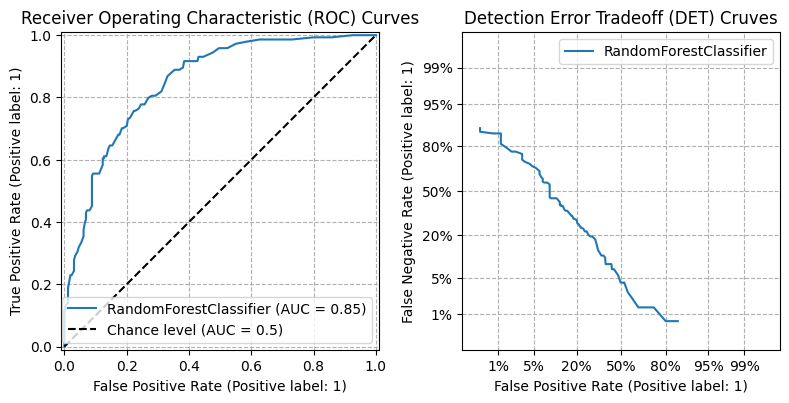

In [36]:
fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(8,8))
RocCurveDisplay.from_estimator(
    clf_rf, X_test, y_test_enc, ax=ax_roc, plot_chance_level=True
)
DetCurveDisplay.from_estimator(
    clf_rf, X_test, y_test_enc, ax=ax_det
)
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curves")
ax_det.set_title("Detection Error Tradeoff (DET) Cruves")
ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')
ax_det.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

Accuracy is the value of correct and closed values

Predictive power is the AUC (area under the curve)

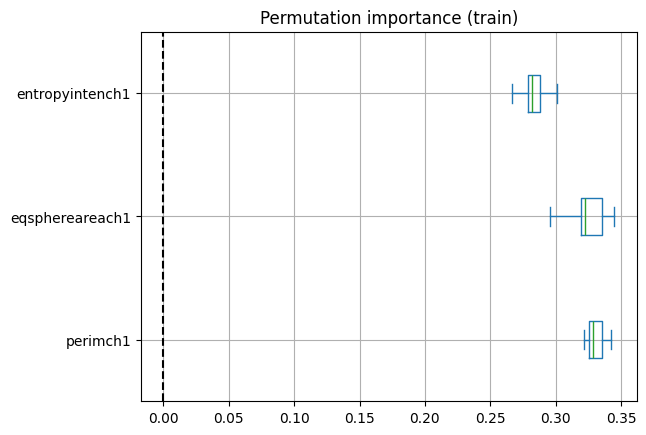

In [42]:
# Calculated importance
importance = permutation_importance(clf_rf, X_train, y_train_enc, n_repeats= 10, random_state= 2024)
importance_df = pd.DataFrame(importance.importances.T, columns= X_train.columns)
ax = importance_df.plot.box(vert= False)
ax.axvline(x= 0, color= 'k', linestyle= '--')
ax.grid(True)
ax.set_title('Permutation importance (train)')
plt.show()

In [45]:
model_dict = {
    'model': clf_rf,
    'predictors': X_train.columns.to_list(),
    'algorithm_name': 'Random Forest Classifier'
}

In [46]:
# Create model .joblib
try:
    joblib.dump(model_dict, 'cell_segmentation_model_rf.joblib')
    logger.info('Saving as successful!')
except Exception as e:
    logger.error(f'An error has ocurred {e}')